In [1]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [3]:
#DESCR IS USED TO ACCESS THE DESCRIPTION OF THE IRIS DATASET

print(iris_data[0].DESCR if isinstance(iris_data, tuple) else iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [11]:
if isinstance(iris_data, tuple):
    features = iris_data[0].data
    labels = iris_data[0].target
else:
    features = iris_data.data
    labels = iris_data.target

In [12]:
#MinMaxScaler IS USED TO NORMALIZE THE FEATURES WITHIN [0,1]
#Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm

from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

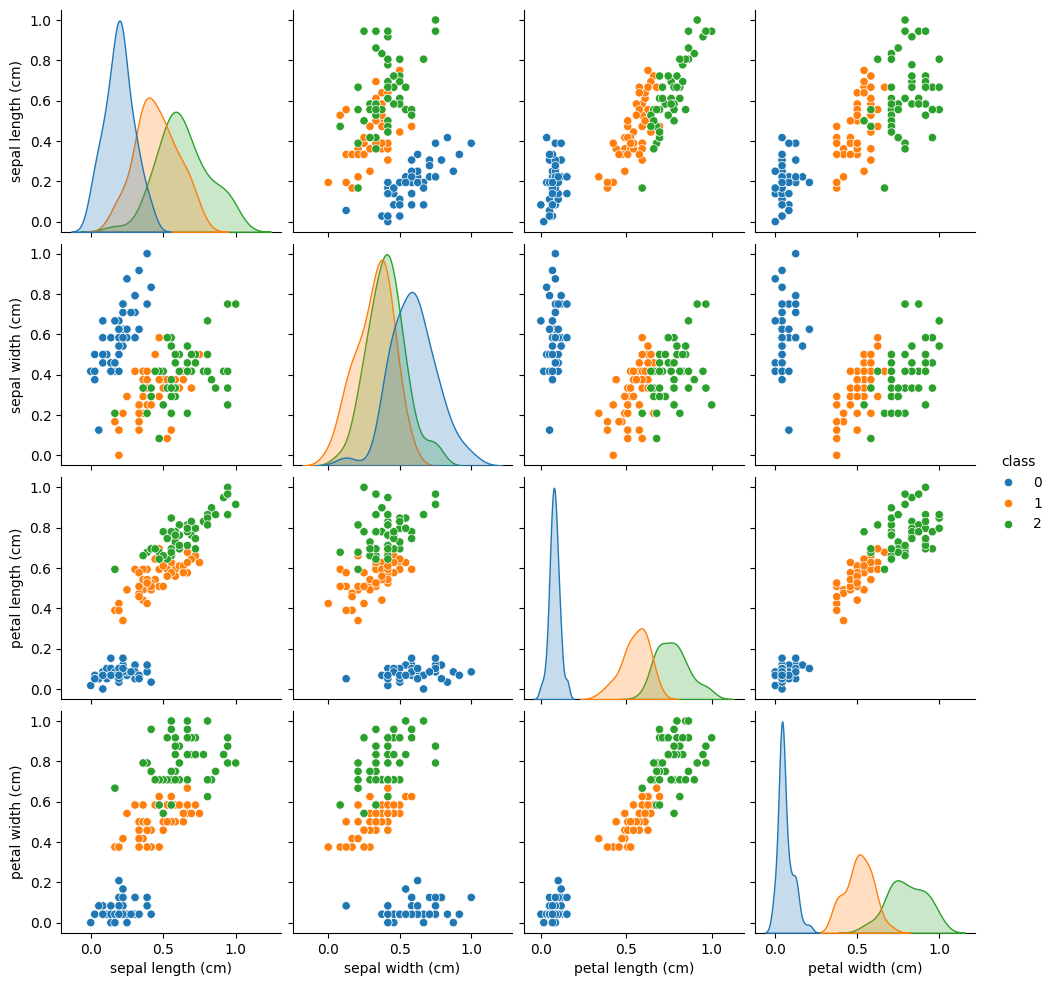

In [15]:
import pandas as pd
import seaborn as sns

#iris_data.target extracts the target variable from the Iris dataset
#df["class"] assigns the pandas Series to a new column named "class"

df = pd.DataFrame(features, columns=iris_data.feature_names) # type: ignore
df["class"] = pd.Series(labels)

#"pairplot" function from the Seaborn library is used to create a pair plot. A pair plot is a grid of scatterplots showing relationships between pairs of variables in a dataset.
#The hue parameter is used to color the data points based on a categorical variable. In this case, the "class"
#palette parameter is used to set the color palette for the different classes. "tab10" is one of the predefined color palettes in Seaborn

sns.pairplot(df, hue="class", palette="tab10")

In [16]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(features, labels,train_size=0.8, random_state=algorithm_globals.random_seed)

ImportError: cannot import name 'BaseSampler' from 'qiskit.primitives' (/Users/proximus/Desktop/Quantum AI ML workshop/.venv/lib/python3.11/site-packages/qiskit/primitives/__init__.py)

In [7]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(train_features, train_labels)

print(f"classical SVC on the training dataset: {train_score_c4: .2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4: .2f}")

classical SVC on the training dataset:  0.99
Classical SVC on the test dataset:      0.99


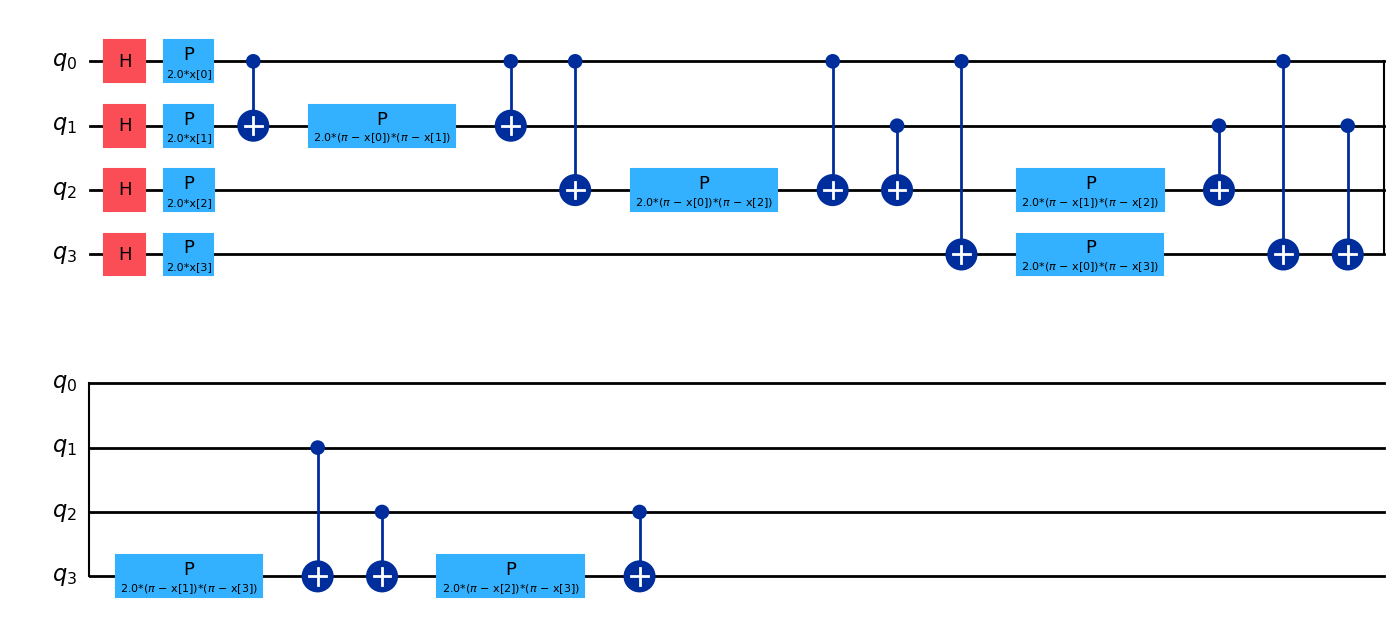

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20, style="iqp") #Be Carefull it's 'mpl' not 'mp1'

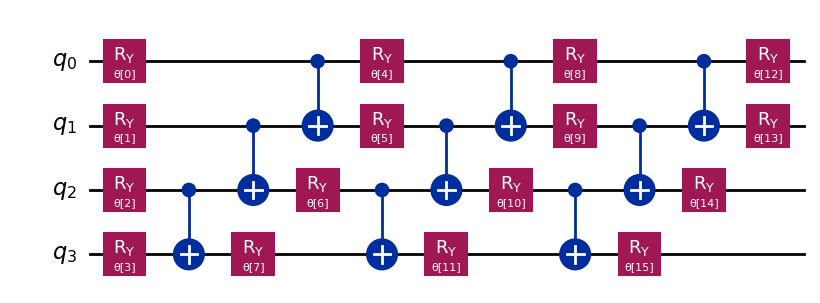

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output='mpl', fold=20, style='iqp')

In [11]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [12]:
#In the next step, we define where to train our classifier.
#We can train on a simulator or a real quantum computer.
#Here, we will use a simulator. We create an instance of the Sampler primitive.
#This is the reference implementation that is statevector based. 
#Using qiskit runtime services you can create a sampler that is backed by a quantum computer.
from qiskit.primitives import Sampler

sampler = Sampler()

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

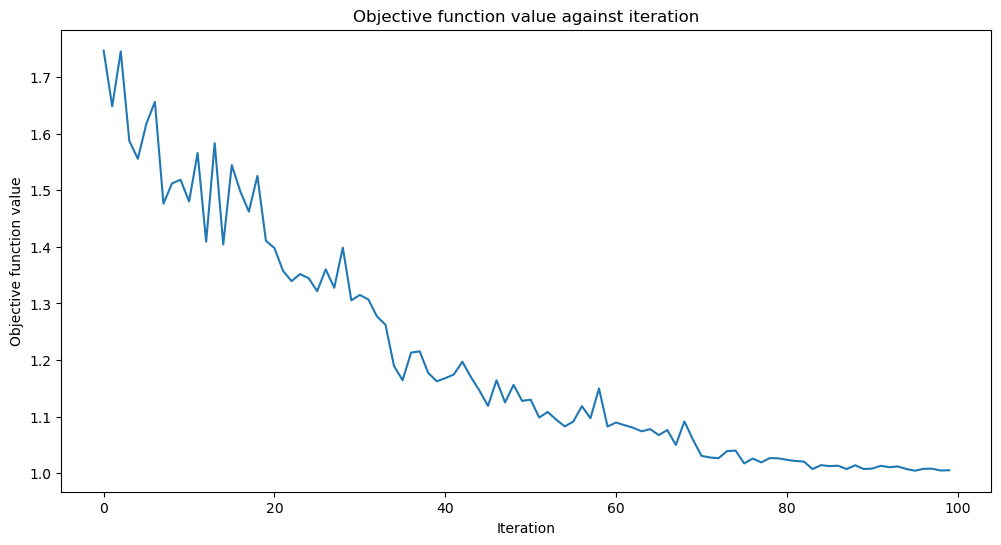

Training time: 209 seconds


In [15]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [16]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


<AxesSubplot: >

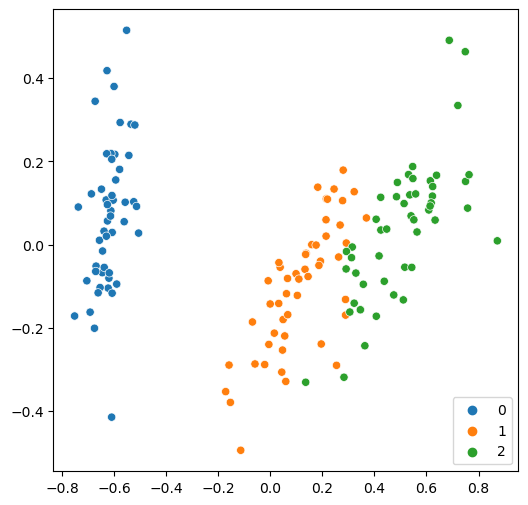

In [23]:
from sklearn.decomposition import PCA

PCAfeatures = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=PCAfeatures[:, 0], y=PCAfeatures[:, 1], hue=labels, palette="tab10")

In [22]:
from sklearn.svm import SVC



(150, 2)

In [24]:
#AGAIN CLASSICALY AFTER DIMENTIONALITY REDUCTION
train2_features, test2_features, train2_labels, test2_labels = train_test_split(
    PCAfeatures, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc2 = SVC()
_ = svc2.fit(train2_features, train2_labels)

train2_score_c2 = svc2.score(train2_features, train2_labels)
test2_score_c2 = svc2.score(test2_features, test2_labels)

print(f"Classical SVC on the training dataset: {train2_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test2_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [17]:
from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')
print(backend.status())

ImportError: cannot import name 'Aer' from 'qiskit' (/Users/proximus/Desktop/Quantum AI ML workshop/.venv/lib/python3.11/site-packages/qiskit/__init__.py)

In [1]:
from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')
status = backend.status()

# Print relevant information
print("Backend name:", status.backend_name)
print("Status message:", status.status_msg)
print("Operational:", status.operational)
print("Pending jobs:", status.pending_jobs)

/var/folders/ky/pp0tmz114kn4vxw_xz8js0gm0000gn/T/ipykernel_21810/2791311998.py:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')


MissingOptionalLibraryError: "The 'qiskit-aer' library is required to use 'Aer provider'. You can install it with 'pip install qiskit-aer'."